<a href="https://colab.research.google.com/github/msevim24/MachineLearning_DeepLearning_Projects/blob/master/TimeSeriesAnalysis_with_LSTM_%20AmazonStockPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis with LSTM: Amazon Stock Prices

dataset @ https://finance.yahoo.com/quote/AMZN/history?p=AMZN

I downloaded and  analyzed the last five years beginning from 29-01-2018 until 27-01-2023.

I used this example in this LSTM project: https://www.youtube.com/watch?v=tepxdcepTbY

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [4]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/amazon.csv')
print(df.head()) #There are 7 columns in total

         Date       Open       High        Low      Close  Adj Close  \
0  2018-01-29  70.459000  71.569504  70.022003  70.884003  70.884003   
1  2018-01-30  70.158501  71.962502  69.599998  71.890999  71.890999   
2  2018-01-31  72.565002  73.628998  72.501999  72.544502  72.544502   
3  2018-02-01  72.250000  72.994003  69.257004  69.500000  69.500000   
4  2018-02-02  73.869499  74.900002  70.699997  71.497498  71.497498   

      Volume  
0  114038000  
1  117438000  
2  128494000  
3  182276000  
4  222514000  


In [5]:
df.shape

(1259, 7)

In [6]:
#Separate dates for futures
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check the last dates.

1244   2023-01-06
1245   2023-01-09
1246   2023-01-10
1247   2023-01-11
1248   2023-01-12
1249   2023-01-13
1250   2023-01-17
1251   2023-01-18
1252   2023-01-19
1253   2023-01-20
1254   2023-01-23
1255   2023-01-24
1256   2023-01-25
1257   2023-01-26
1258   2023-01-27
Name: Date, dtype: datetime64[ns]


In [7]:
#Variables for training
cols = list(df)[1:6] # Date and Volume colums are excluded
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [8]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(1000) # plot the last 1000 data points 
# df_for_plot.plot.line()

If there are significant difference between values, we need to normalize the data because LSTM uses sigmoid and tanh that are sensitive to magnitude.

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [10]:
df_for_training_scaled.shape

(1259, 5)

In [11]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [12]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (1259, 5)
#1259 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [13]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1245, 14, 5).
trainY shape == (1245, 1).


In my case, trainX has a shape (1245, 14, 5). 
It is 1245 because we are looking back 14 days (1259 - 14 = 1245). 

Also, trainY has a shape (1245, 1). Our model only predicts a single value, but it needs multiple variables (5 in my example) to make this prediction. 

This is why we can only predict a single day after our training, the day after where our data ends. To predict more days in future, we need all the 5 variables which we do not have. 


In [14]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [15]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
70/70 [==============================] - 5s 25ms/step - loss: 0.1313 - val_loss: 0.0379
Epoch 2/5
70/70 [==============================] - 2s 22ms/step - loss: 0.0500 - val_loss: 0.0332
Epoch 3/5
70/70 [==============================] - 2s 23ms/step - loss: 0.0455 - val_loss: 0.0290
Epoch 4/5
70/70 [==============================] - 2s 22ms/step - loss: 0.0426 - val_loss: 0.0326
Epoch 5/5
70/70 [==============================] - 2s 22ms/step - loss: 0.0446 - val_loss: 0.0236


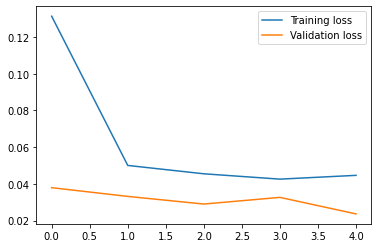

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [18]:
"""
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back or forward.  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
"""

'\n#Predicting...\n#Libraries that will help us extract only business days in the US.\n#Otherwise our dates would be wrong when we look back or forward.  \nfrom pandas.tseries.holiday import USFederalHolidayCalendar\nfrom pandas.tseries.offsets import CustomBusinessDay\nus_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())\n'

In [19]:
"""
#Remember that we can only predict one day in future as our model needs 5 variables as inputs for prediction. 
#We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days
"""

'\n#Remember that we can only predict one day in future as our model needs 5 variables as inputs for prediction. \n#We only have all 5 variables until the last day in our dataset.\nn_past = 16\nn_days_for_prediction=15  #let us predict past 15 days\n'

In [20]:
n_future=60
predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [21]:
#Make prediction
prediction = model.predict(trainX[-n_future:]) #shape = (n, 1) where n is the n_days_for_prediction

2/2 [==============================] - 0s 10ms/step


In [22]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [23]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [24]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [25]:
df_forecast # the next 60 days

,Date,Open
0,2023-01-27,112.729645
1,2023-01-28,110.417259
2,2023-01-29,107.822838
3,2023-01-30,105.109581
4,2023-01-31,102.427788
5,2023-02-01,99.948235
6,2023-02-02,97.798218
7,2023-02-03,95.698502
8,2023-02-04,94.903633
9,2023-02-05,95.269043


In [26]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-1-1']

<ipython-input-26-27542f55416b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [27]:
original.tail() # the last dates of original data

,Date,Open
1254,2023-01-23,97.559998
1255,2023-01-24,96.930000
1256,2023-01-25,92.559998
1257,2023-01-26,98.239998
1258,2023-01-27,99.529999


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


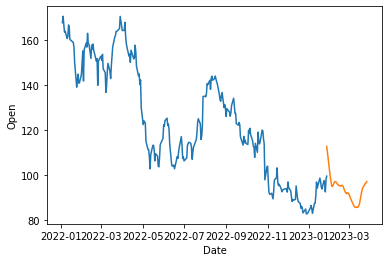

In [28]:
sns.lineplot(original['Date'], original['Open']) # blue line
sns.lineplot(df_forecast['Date'], df_forecast['Open']) # orange line